In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.77MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

LATENT_DIM = 32
model = DenoisingAutoencoder(latent_dim=LATENT_DIM).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        noisy_inputs = inputs + 0.5 * torch.randn_like(inputs)
        noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

        noisy_inputs = noisy_inputs.to(device)
        targets = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1/10, Loss: 0.0552
Epoch 2/10, Loss: 0.0310
Epoch 3/10, Loss: 0.0260
Epoch 4/10, Loss: 0.0238
Epoch 5/10, Loss: 0.0222
Epoch 6/10, Loss: 0.0209
Epoch 7/10, Loss: 0.0201
Epoch 8/10, Loss: 0.0195
Epoch 9/10, Loss: 0.0190
Epoch 10/10, Loss: 0.0186


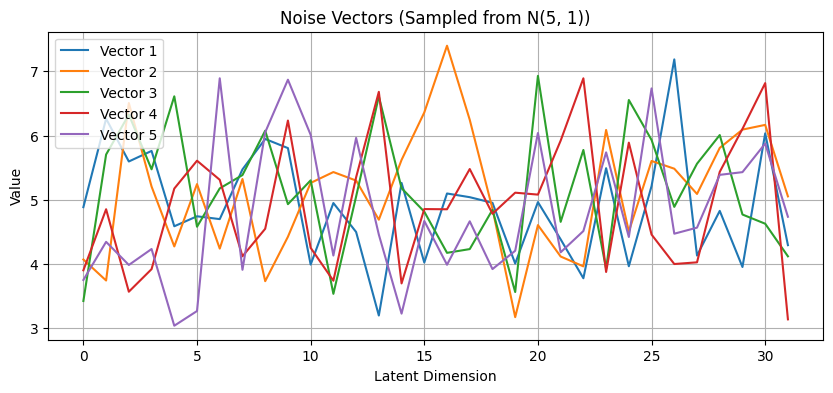

In [ ]:
model.eval()
num_images = 5
noise = torch.normal(mean=5.0, std=1.0, size=(num_images, LATENT_DIM)).to(device)

plt.figure(figsize=(10, 4))
for i in range(num_images):
    plt.plot(noise[i].cpu().numpy(), label=f"Vector {i+1}")
plt.title("Noise Vectors (Sampled from N(5, 1))")
plt.xlabel("Latent Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

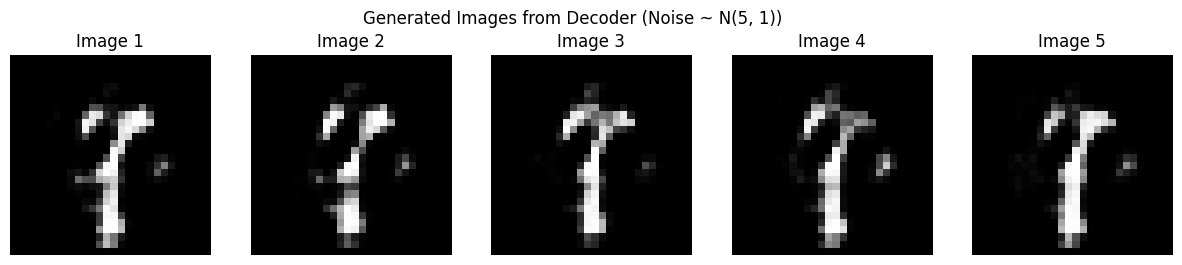

In [ ]:
# Part 6: Decode and Visualize Generated Images
with torch.no_grad():
    generated_images = model.decoder(noise)

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    img = generated_images[i].cpu().squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")
plt.suptitle("Generated Images from Decoder (Noise ~ N(5, 1))")
plt.show()